In [1]:
!pip install dionysus
!pip install zarr
!pip install POT
!pip install gudhi
!pip install validclust

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.9-cp39-cp39-linux_x86_64.whl size=343943 sha256=f7a28b38a918e659cbf3d53ed698d8d4493f438aef0d650fd2736abd6519fe9b
  Stored in directory: /root/.cache/pip/wheels/f1/2d/23/0540e5b7840f02182e93a3c56a2669646d509eae05afb2c7ac
Successfully built dionysus
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 67.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=7662c993df5bab2ad4640035309f3957fc7e7d0aa692a7eafb9fe4762f400589
  Stored in directory: /ro

In [2]:
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive',force_remount=True)
os.chdir("/content/drive/My Drive/NASA/Fire Detection/Test Data")
!ls -ltr

Mounted at /content/drive
total 115
drwx------ 2 root root  4096 Jan 19 03:20 Tile_1_33
drwx------ 2 root root  4096 Jan 19 03:21 Tile_5_37
drwx------ 2 root root  4096 Jan 21 00:56 Tile_0_8
drwx------ 2 root root  4096 Jan 23 23:39 Tile_2_6
drwx------ 2 root root  4096 Jan 23 23:40 Tile_17_32
drwx------ 2 root root  4096 Jan 25 01:24 Tile_13_37
-rw------- 1 root root 22342 Feb  8 16:02 clusters_2norm.pdf
drwx------ 2 root root  4096 Mar  7 01:55 Tile_0_35
drwx------ 2 root root  4096 Mar  7 01:55 Tile_0_24
drwx------ 2 root root  4096 Mar  7 01:55 Tile_0_32
drwx------ 2 root root  4096 Mar  7 01:56 Tile_1_38
drwx------ 2 root root  4096 Mar  7 01:56 Tile_2_32
drwx------ 2 root root  4096 Mar  7 01:56 Tile_2_33
drwx------ 2 root root  4096 Mar  7 01:57 Tile_2_35
drwx------ 2 root root  4096 Mar  7 01:57 Tile_3_33
drwx------ 2 root root  4096 Mar  7 01:57 Tile_5_35
drwx------ 2 root root  4096 Mar  7 01:57 Tile_6_33
drwx------ 2 root root  4096 Mar  7 01:58 Tile_6_38
drwx------ 2 root r

In [3]:
import zarr
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import dionysus as d
import matplotlib.pyplot as plt
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance as wd
from gudhi.representations import Landscape
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from validclust import dunn, cop, ValidClust
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import gudhi
sns.set_theme()

In [4]:
fname2 = 'Tile_1_33'

rawFileList = os.listdir(fname2)
print (rawFileList)

['Tile_1_33.csv', 'Tile_1_33_s20192210221197.zarr', 'Tile_1_33_s20192192041196.zarr', 'Tile_1_33_s20192201851196.zarr', 'Tile_1_33_s20192210116197.zarr', 'Tile_1_33_s20192210121197.zarr', 'Tile_1_33_s20192192006196.zarr', 'Tile_1_33_s20192192026196.zarr', 'Tile_1_33_s20192200056197.zarr', 'Tile_1_33_s20192201931196.zarr', 'Tile_1_33_s20192200236197.zarr', 'Tile_1_33_s20192181926196.zarr', 'Tile_1_33_s20192191821196.zarr', 'Tile_1_33_s20192182036196.zarr', 'Tile_1_33_s20192181816196.zarr', 'Tile_1_33_s20192182151196.zarr', 'Tile_1_33_s20192191931196.zarr', 'Tile_1_33_s20192191956196.zarr']


In [5]:
dfLabel = pd.read_csv(fname2 + '//' + rawFileList[0])
dfLabel['name'] = dfLabel.apply(lambda row: row.scene.split('_')[3], axis=1)
label = dfLabel.loc[dfLabel['name'] == 's20192210221197', 'fire'].iloc[0]
print (label)

0


In [6]:
timeSeriesName = rawFileList[1:]

channel7List = []
channel7Name = []
for name in timeSeriesName:
    channelData = np.array(zarr.open(fname2 + '//' + name)[:, :, 6]) # select channel 7
    channel7List.append(channelData)
    channel7Name.append(name)
    
print (len(channel7List))

17


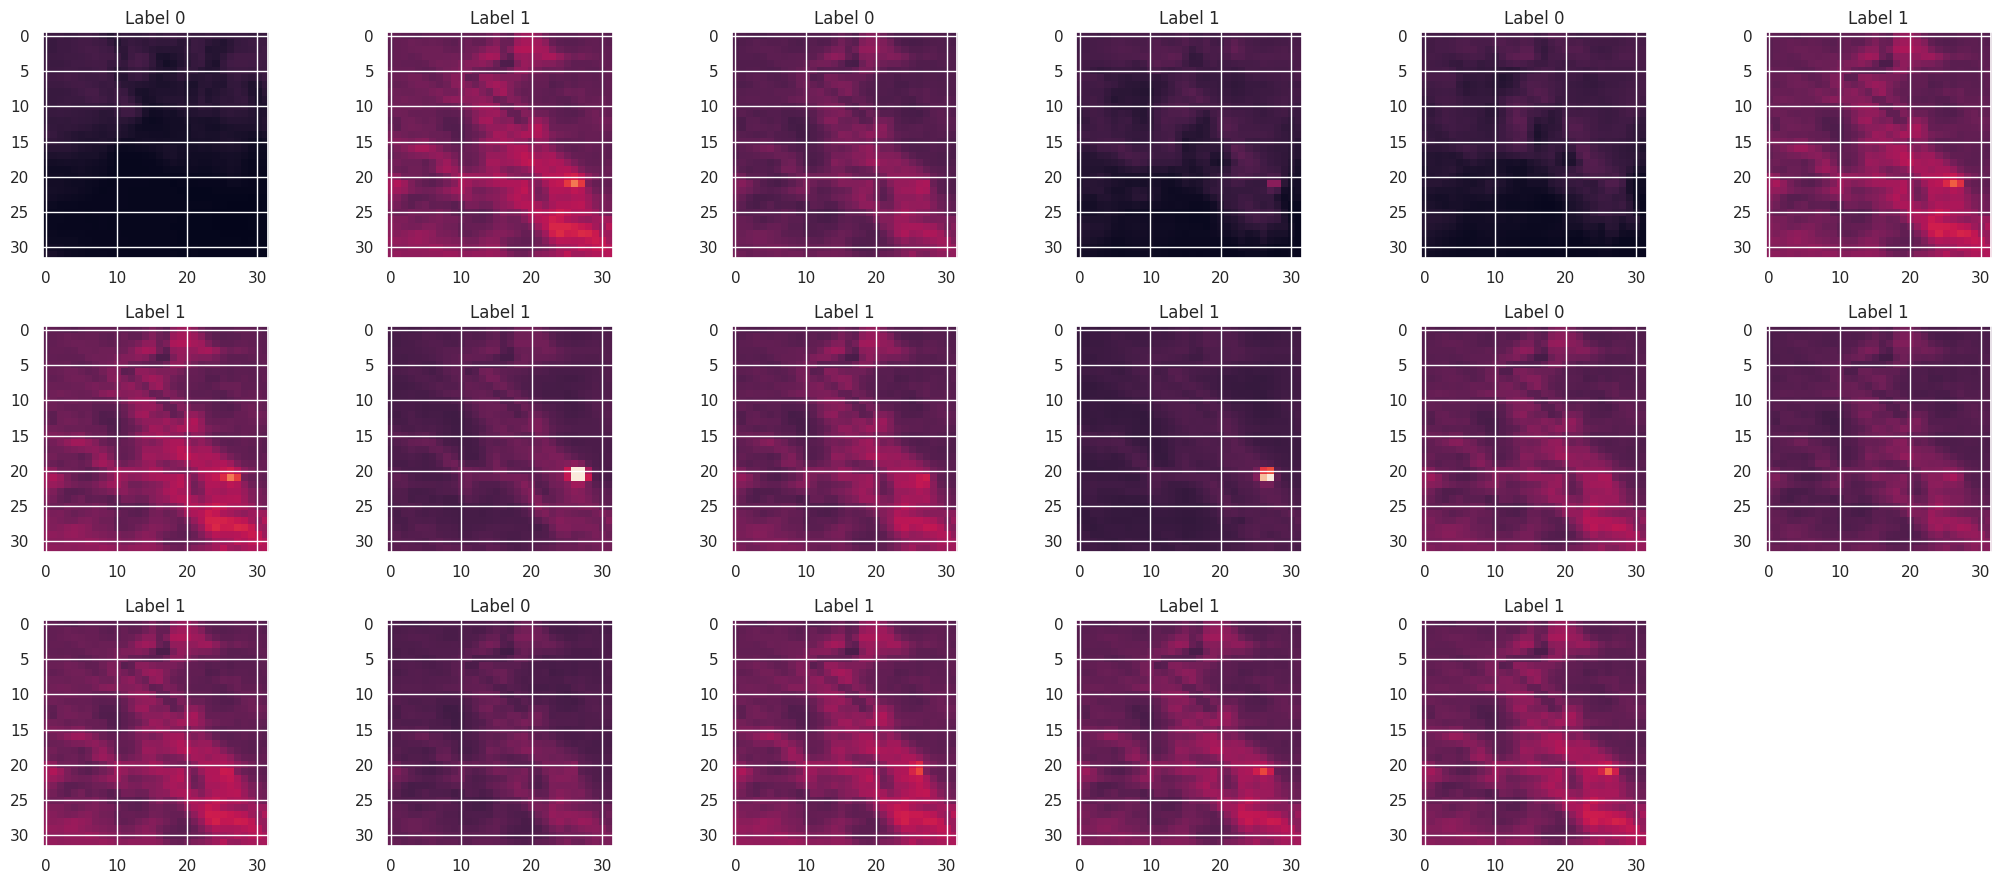

In [7]:
# plot channel 7 timeseries
fig, axs = plt.subplots(3, 6, figsize=(21, 9))

for i in range(3):
    for j in range(6):
        if i* 6 + j <= 16:
            axs[i, j].imshow(channel7List[i* 6 + j], vmin=0, vmax=4) # vmin, vmax may change on different tiles
            seriesStartTime = channel7Name[i* 6 + j].split('_')[3].split('.')[0]
            label = dfLabel.loc[dfLabel['name'] == seriesStartTime, 'fire'].iloc[0]
            axs[i, j].title.set_text('Label {}'.format(label))

fig.delaxes(axs[2, 5])
plt.tight_layout()

In [8]:
def extract_PD_arrays_with_freudenthal_triangulation(data, lower_bound = 0, upper_bound = 8):
    
    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = upper_bound 
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = upper_bound
   
    return [[birth0,death0],[birth1,death1]]

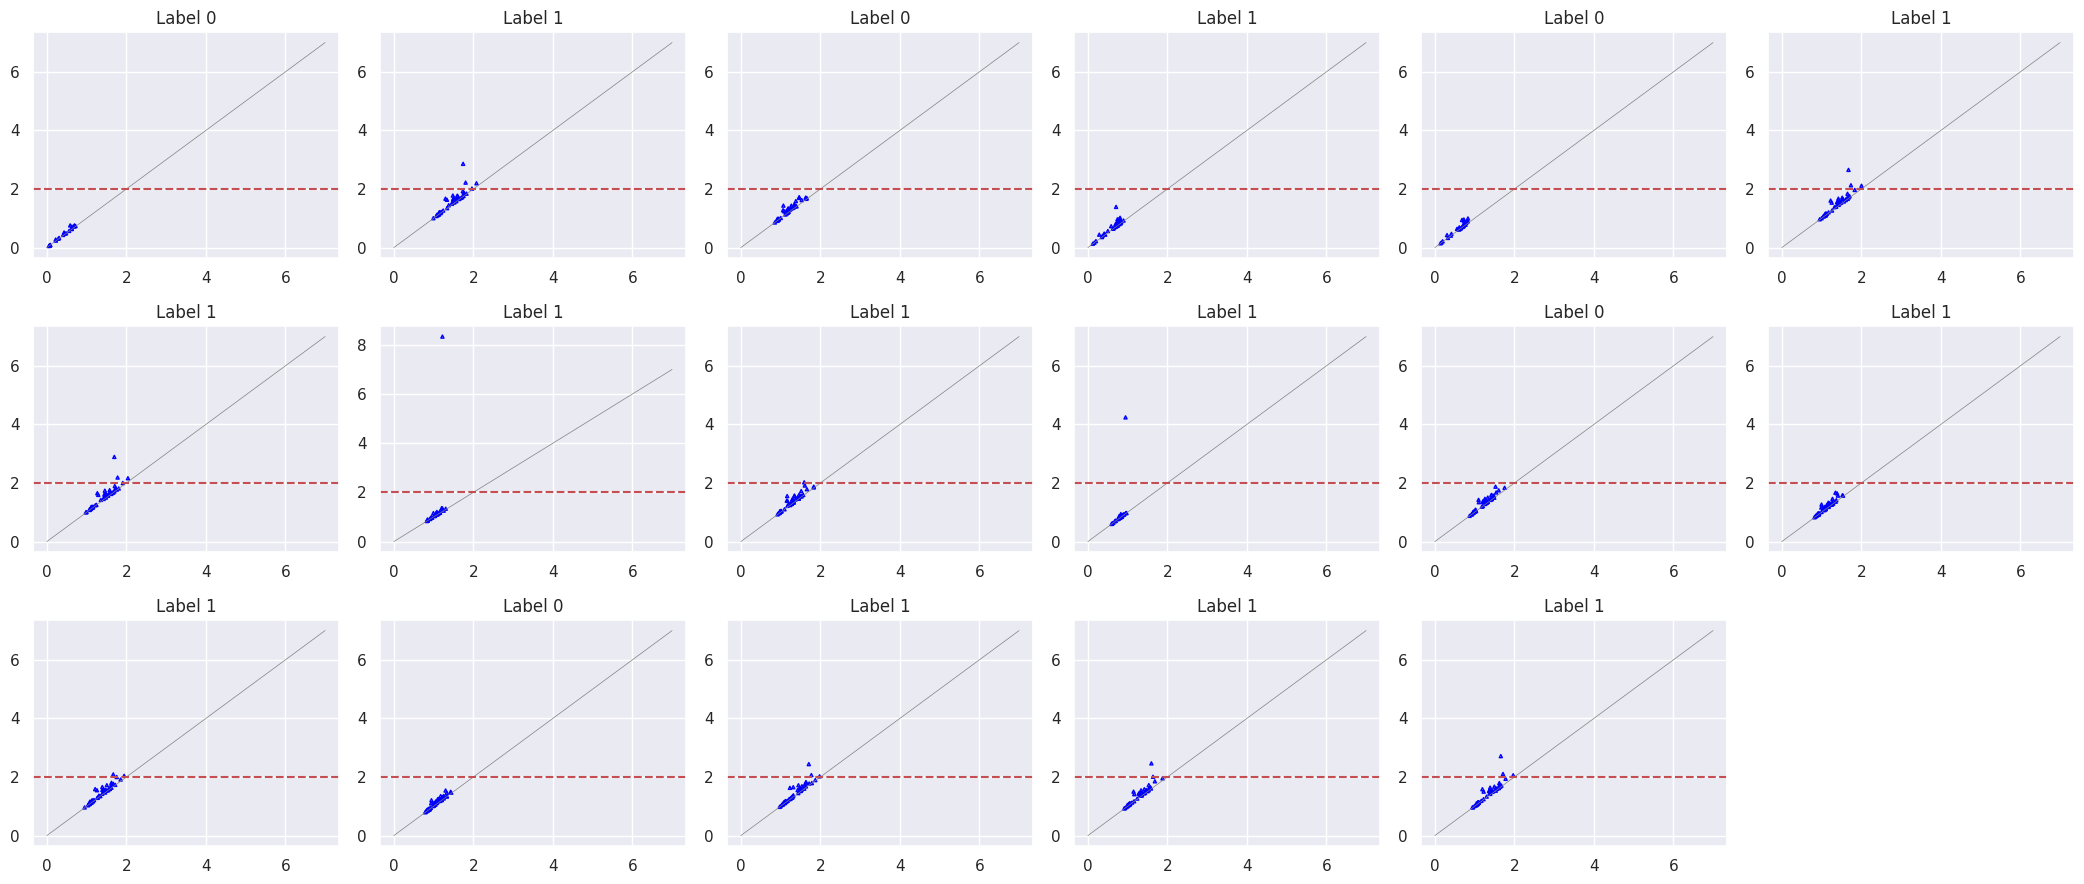

In [9]:
fig, axs = plt.subplots(3, 6, figsize=(21, 9))

pd0_union = []
pd1_union = []
groundTruth = []
for i in range(3):
    for j in range(6):
        if i* 6 + j <= 16:
            lower_bound = 0
            upper_bound = 8
            
            p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(channel7List[i* 6 + j], lower_bound = lower_bound, upper_bound = upper_bound)
            pd0_union.append(p0)
            pd1_union.append(p1)
            #axs[i, j].scatter(birth0, death0, color='r', s=5, label = 'Dimension 0')
            axs[i, j].scatter(p1[0], p1[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
            #axs[i, j].scatter(p0[0], p0[1], marker='^', s=5, facecolors='none', edgecolor='red', label = 'Dimension 0')
            axs[i, j].plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
            #axs[i, j].plot(np.arange(lower_bound, upper_bound), 2, '-', color='grey', lw=0.5)
            axs[i, j].axhline(y = 2, color='r', linestyle='--')

            seriesStartTime = channel7Name[i* 6 + j].split('_')[3].split('.')[0]
            label = dfLabel.loc[dfLabel['name'] == seriesStartTime, 'fire'].iloc[0]
            groundTruth.append(label)
            axs[i, j].title.set_text('Label {}'.format(label))
            #axs[i, j].set_xlabel('Birth')
            #axs[i, j].set_ylabel('Death')

fig.delaxes(axs[2, 5])
plt.tight_layout()
plt.show()

In [10]:
def PD2Silhoutte(PDList, resolution = 100):
    SH = gd.representations.Silhouette(resolution=resolution, weight=lambda x: np.power(x[1]-x[0],1))
    SilList = []
    for i in range(len(PDList)):
        sh = SH.fit_transform([PDList[i]])[0]
        SilList.append(sh)
    return SilList

In [11]:
print (groundTruth)

[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]


In [12]:
SimplicialVolDepth = [0.9782665, 0.9598752 , 0.9803188, 0.9715499 , 0.979676 , 0.968288 , 0.954594 , 0.4730382, 0.9818818 , 0.6771605 , 0.9807952 , 0.9813164 , 0.9812129 , 0.9795362 , 0.9805354 , 0.9723188 , 0.962765 ]
MahalanobisDepth = [0.002801779 , 0.0007643811 , 0.003461097, 0.001718851 , 0.003569017 , 0.00129248 , 0.0005781345 , 1.024727e-06, 0.00449369 , 5.494704e-06, 0.003635411 , 0.004080145 , 0.003997883 , 0.003156999 , 0.003800881 , 0.001744575 , 0.0008911805 ]
L2Depth = [0.01173836 , 0.003238764 , 0.01446192, 0.007250748 , 0.01494399 , 0.005466235 , 0.002450623 , 4.340612e-06, 0.01867772 , 2.327896e-05, 0.01518336 , 0.01702498, 0.01668554, 0.01320459, 0.01580698 , 0.007363948, 0.00377537 ]
ProjectionDepth = [0.4235424 , 0.5364461 , 0.4401903 , 0.5045235 , 0.4361627 , 0.5242305 , 0.546128, 0.006841718 , 0.454619 , 0.01607065 , 0.4400693 , 0.44301 , 0.4494269 , 0.4292055 , 0.5080145 , 0.5187442 , 0.534255 ]
PotentialDepth = [2.681449e-99 , 0 , 9.382436e-81, 1.196921e-164, 2.257905e-77,  3.520092e-228, 0, 0, 1.414754e-58 , 0, 6.683e-77, 6.799231e-67, 9.882489e-69 , 1.300113e-88 , 6.091796e-67, 9.129385e-165, 0]
BetaSkeletonDepth = [0.1985294 , 0.3676471, 0.375 , 0.2573529 , 0.2058824 , 0.3014706 , 0.4264706 , 0 , 0.3382353 , 0.125 , 0.3308824 , 0.25, 0.3676471 , 0.2647059 , 0.2647059 , 0.2867647, 0.3455882 ]

def NormalizeL(l):
    output = []
    maxVal = np.max(l)
    minVal = np.min(l)
    for v in l:
        temp = (v - minVal) / (maxVal - minVal)
        output.append(temp)

    return output

#groundTruth = [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
#plt.plot(NormalizeL(MahalanobisDepth))
#plt.show()

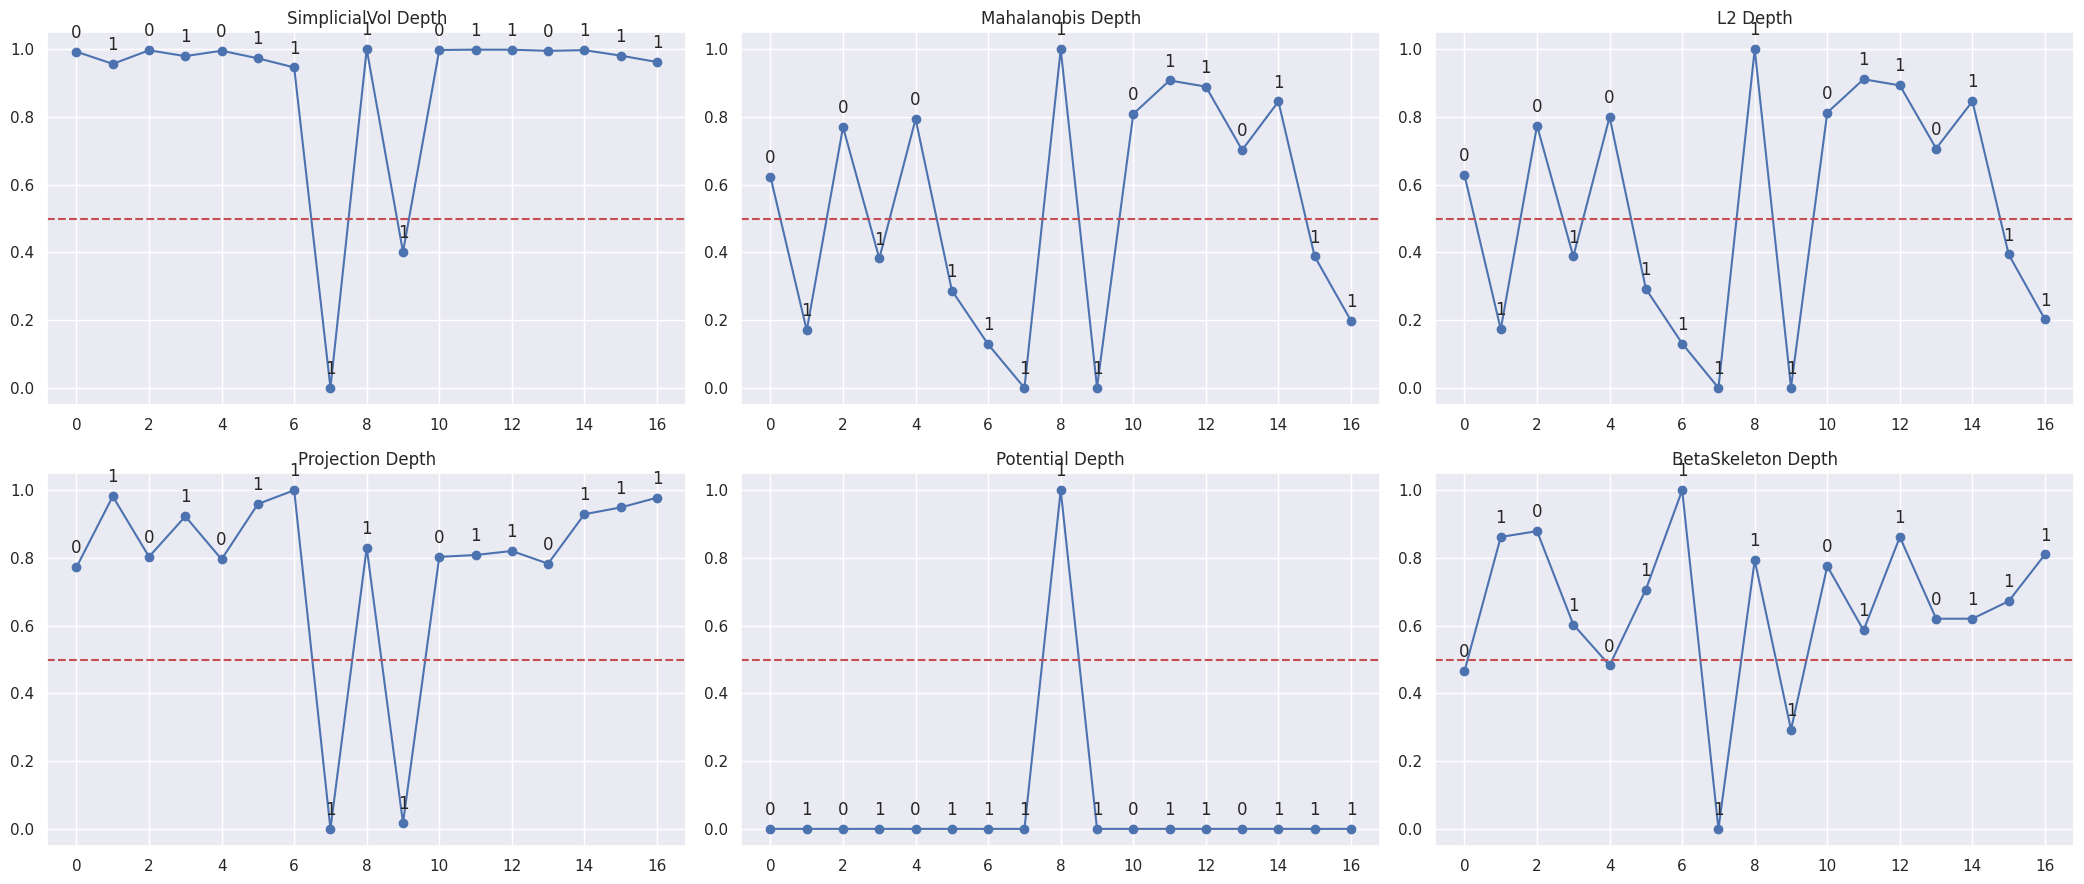

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(21, 9))

depthList = [SimplicialVolDepth, MahalanobisDepth, L2Depth, ProjectionDepth, PotentialDepth, BetaSkeletonDepth]
depthNameList = ['SimplicialVol Depth', 'Mahalanobis Depth', 'L2 Depth', 'Projection Depth', 'Potential Depth', 'BetaSkeleton Depth']

for i in range(2):
    for j in range(3):
        
        xs = np.arange(0,17,1)
        ys = NormalizeL(depthList[i * 3 + j])

        # 'bo-' means blue color, round points, solid lines
        axs[i, j].plot(xs,ys,'bo-')

        # zip joins x and y coordinates in pairs
        count = 0
        for x,y in zip(xs,ys):

            label = "{}".format(groundTruth[count])

            axs[i, j].annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center
            count += 1
        axs[i, j].axhline(y = 0.5, color='r', linestyle='--')
        axs[i, j].title.set_text('{}'.format(depthNameList[i * 3 + j]))

plt.tight_layout()
plt.show()

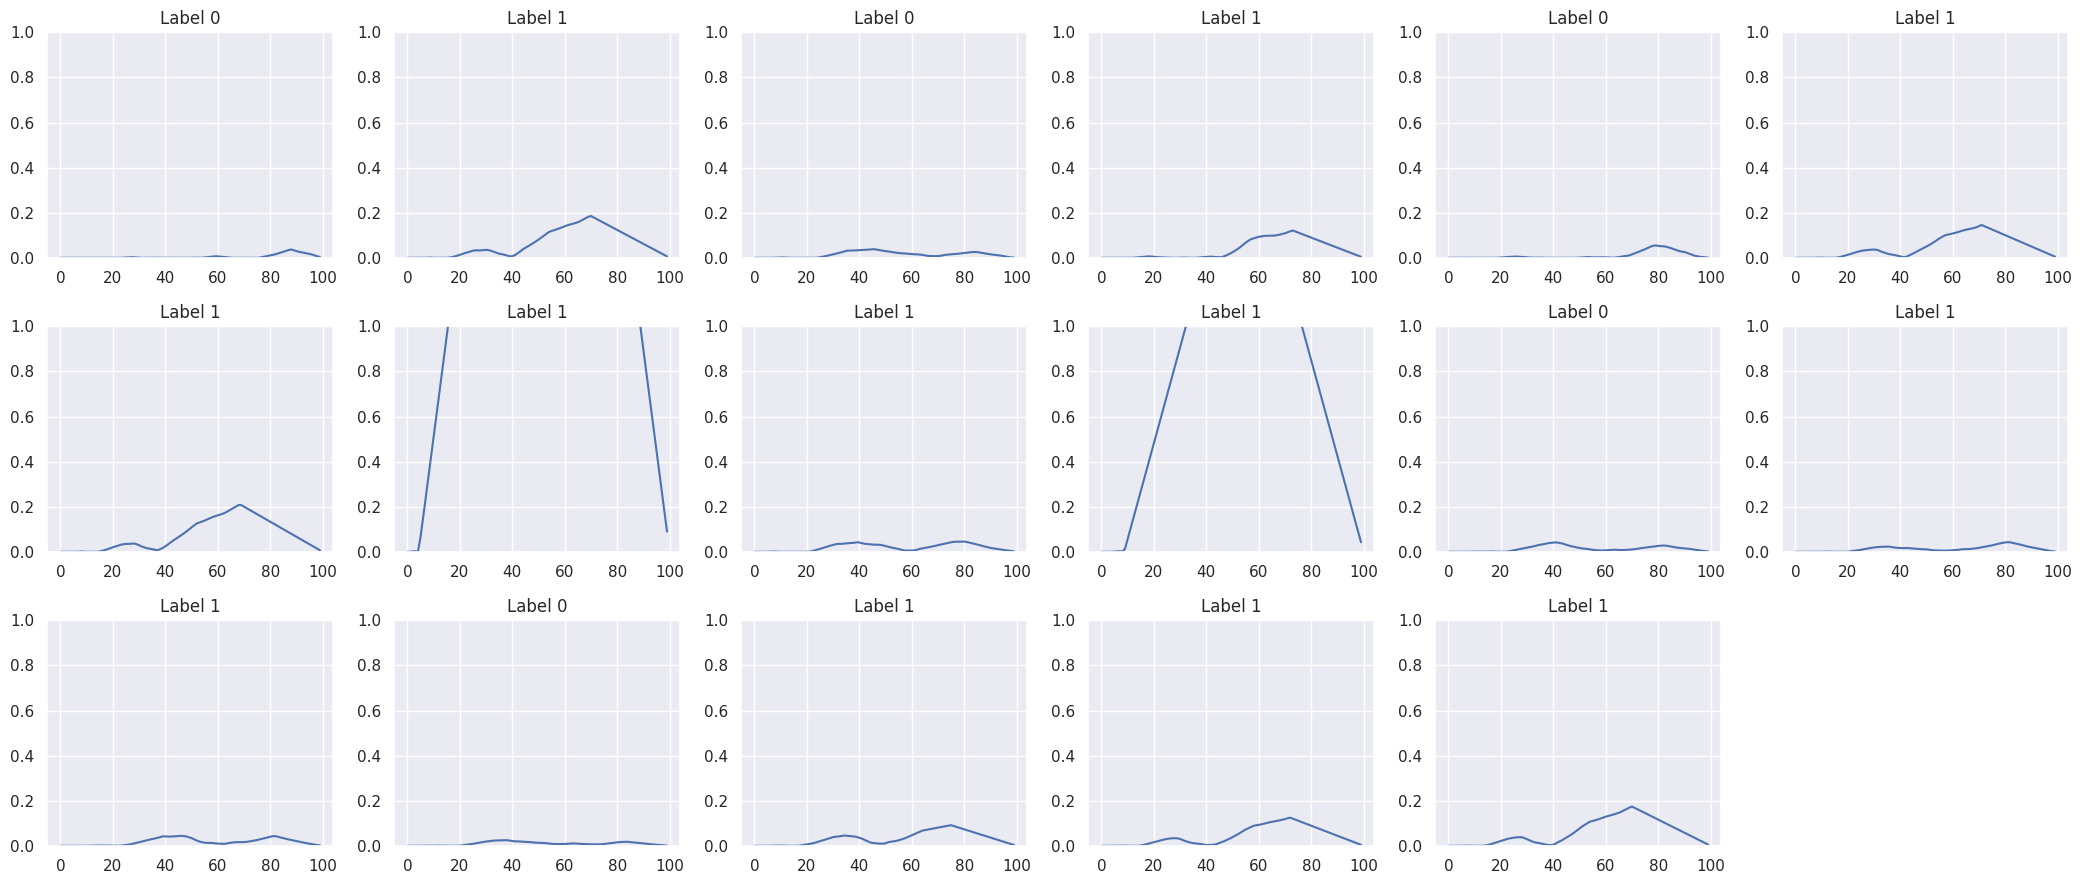

In [21]:
PDList = []
for i in pd1_union:
    temp = np.vstack((i[0], i[1])).T
    PDList.append(temp)

# Vectorize the PDs then do cluster
# Vectorize by Silhoutte
SilList = PD2Silhoutte(PDList, resolution=100)

# print (SilList)

# Result from R
# simplexVolDepthList = [0.9782665, 0.9598752, 0.9803188, 0.9715499, 0.979676, 0.968288, 0.954594, 0.4730382, 0.9818818, 0.6771605, 0.9807952, 0.9813164, 0.9812129, 0.9795362, 0.9805354, 0.9723188, 0.962765, 0.000]

fig, axs = plt.subplots(3, 6, figsize=(21, 9))
for i in range(3):
    for j in range(6):
        if i* 6 + j <= 16:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            axs[i, j].title.set_text('Label {}'.format(groundTruth[i*6 + j]))

fig.delaxes(axs[2, 5])
plt.tight_layout()
plt.show()